In [1]:
# clone the repo
!git clone --recursive https://github.com/ApurvaBhargava/pytorch-classification
# switch to repo's directory
import os
os.chdir('pytorch-classification')
os.getcwd()

Cloning into 'pytorch-classification'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 332 (delta 9), reused 36 (delta 6), pack-reused 287
Receiving objects: 100% (332/332), 88.37 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule 'utils/progress' (https://github.com/verigak/progress.git) registered for path 'utils/progress'
Cloning into '/content/pytorch-classification/utils/progress'...
remote: Enumerating objects: 306, done.        
remote: Counting objects: 100% (42/42), done.        
remote: Compressing objects: 100% (31/31), done.        
remote: Total 306 (delta 19), reused 28 (delta 11), pack-reused 264        
Receiving objects: 100% (306/306), 662.72 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule path 'utils/progress': checked out '715a2e130f14fa95c092c771813fb1c729dae333'


'/content/pytorch-classification'

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import models.cifar as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.nn import Softmax
import cv2
from collections import defaultdict
import pandas as pd
from scipy.stats import entropy

In [3]:
# Load and transform the test data

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataloader = datasets.CIFAR100
num_classes = 100

testset = dataloader(root='./data', train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Get class names
class_names = testset.classes


Extracting ./data/cifar-100-python.tar.gz to ./data


In [4]:
# Get model blueprint and load from checkpoint
model = models.__dict__['densenet'](
                    num_classes=100,
                    depth=100,
                    growthRate=12,
                    compressionRate=2,
                    dropRate=0,
                )
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/model_best.pth.tar')
best_acc = checkpoint['best_acc']
print('Validation accuracy: ' + str(best_acc.item()))
model.load_state_dict(checkpoint['state_dict'])

# Get targets and outputs
output_list = []
target_list = []
softmax = Softmax(dim=1)
model.eval()
for batch_idx, (inputs, targets) in enumerate(testloader):
  inputs, targets = inputs.cuda(), targets.cuda()
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
  # compute output
  outputs = softmax(model(inputs)).detach().cpu().numpy()
  outputs = np.argmax(outputs, axis=1)
  output_list.extend(outputs)
  target_list.extend(targets.detach().cpu().numpy())
print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))

Validation accuracy: 77.0999984741211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Correct out of 10000: 7710


In [5]:
# Print output for misclassified images for best model
for i in range(len(output_list)):
  if output_list[i]!=target_list[i]:
    pass
    #print("{} -> {}".format(class_names[output_list[i]], class_names[target_list[i]]))

In [9]:
class_names[testset[78][1]], testset[78][1]

('snail', 77)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


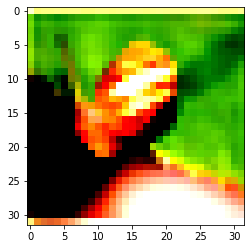

In [6]:
img = testset[78][0].unsqueeze(0).cuda()
plt.imshow(np.transpose(img.detach().cpu().numpy().squeeze(0), (1,2,0)))

module.dense1.1.bn1.weight


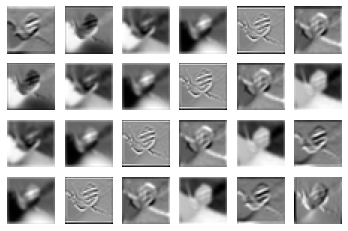

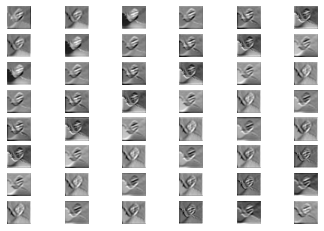

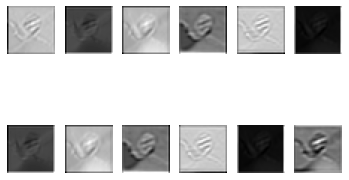

In [ ]:
def eval_name(layer_name):
  temp = 'model'
  for x in layer_name.split('.'):
    if x.isnumeric():
      temp+='['+x+']'
    elif x!='weight' and x!='bias':
      temp+= '.'+x
  return eval(temp)

outputs = []
isFirst = 1
for name, param in model.named_parameters():
  try:
    if isFirst:
      result = eval_name(name)(img)
      isFirst = 0
    else:
      result = eval_name(name)(result)
    if 'conv' in name:
      outputs.append(result)
  except:
    print(name)
    break

fig, axes = plt.subplots(4,6)
for i in range(4):
  for j in range(6):
    axes[i][j].imshow(outputs[0].detach().cpu().numpy().squeeze(0)[i+j], cmap='gray')
    axes[i][j].axis('off')
fig, axes = plt.subplots(8,6)
for i in range(8):
  for j in range(6):
    axes[i][j].imshow(outputs[1].detach().cpu().numpy().squeeze(0)[i+j], cmap='gray')
    axes[i][j].axis('off')
fig, axes = plt.subplots(2,6)
for i in range(2):
  for j in range(6):
    axes[i][j].imshow(outputs[2].detach().cpu().numpy().squeeze(0)[i+j], cmap='gray')
    axes[i][j].axis('off')

In [ ]:
!pip install torch_intermediate_layer_getter

  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-cp37-none-any.whl size=3725 sha256=2711bfe346b46f3f209ff642809bd365adee5ed857227d042636c33ee00e35a9
  Stored in directory: /root/.cache/pip/wheels/57/49/37/bb994f7d4154a414ae11e9f51d2b24a05a99898274b73440e6
Successfully built torch-intermediate-layer-getter


In [ ]:
conv_dict = {}
i=1
for name, _ in model.named_modules():
  if 'conv' in name:
    conv_dict[name] = 'conv'+str(i)
    i+=1

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

return_layers = conv_dict

mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
mid_outputs, model_output = mid_getter(img)

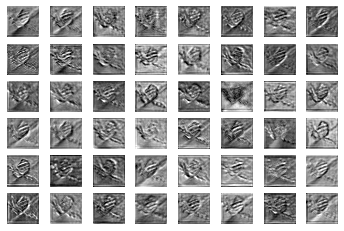

In [ ]:
def show_images(images, cols = 1, titles = None, title2='Image'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    #plt.title(title2)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis('off')
        #a.set_title()
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.axis('off')
    plt.show()
show_images(output, cols=6)

ConvLayer2


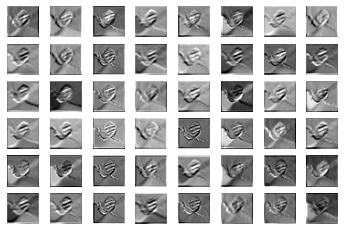

ConvLayer6


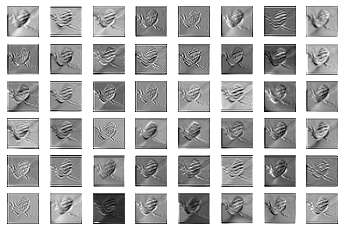

ConvLayer10


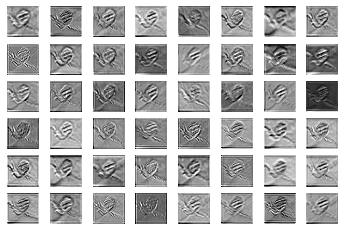

ConvLayer14


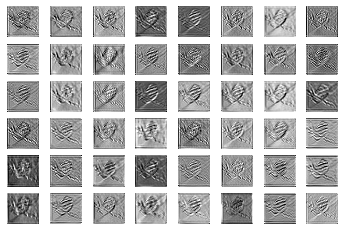

ConvLayer18


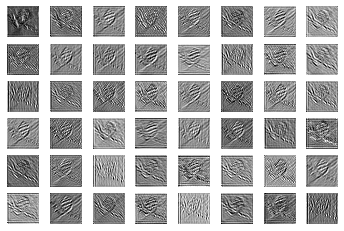

ConvLayer22


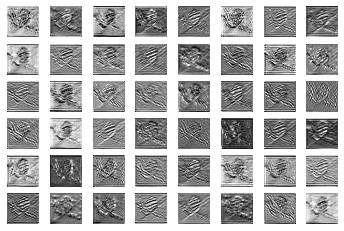

ConvLayer26


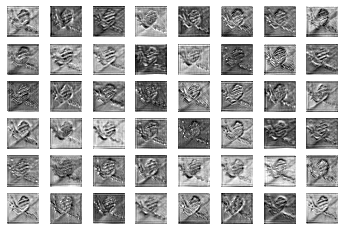

ConvLayer30


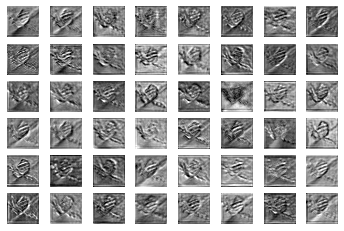

In [ ]:
for k in range(2,32, 4):
  output = mid_outputs['conv'+str(k)].detach().cpu().numpy().squeeze(0)
  print('ConvLayer'+str(k))
  show_images(output, cols=6)